# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook.

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

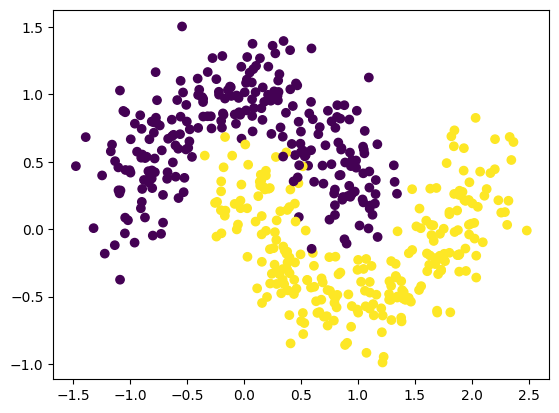

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import f1_score
from mlxtend.plotting import plot_decision_regions

In [4]:
def plot_decisions(X, y, estimator, ax, title=""):
    plot_decision_regions(X=X, y=y, clf=estimator, ax=ax)
    ax.set_title(title)

In [7]:
lr = LogisticRegression(penalty='elasticnet', l1_ratio=0.2, solver='saga', C=0.5)
svm = SVC(kernel='linear', C=0.5)

lr.fit(moons_points, moons_labels)
lr_f1 = f1_score(moons_labels, lr.predict(moons_points))

svm.fit(moons_points, moons_labels)
svm_f1 = f1_score(moons_labels, svm.predict(moons_points))

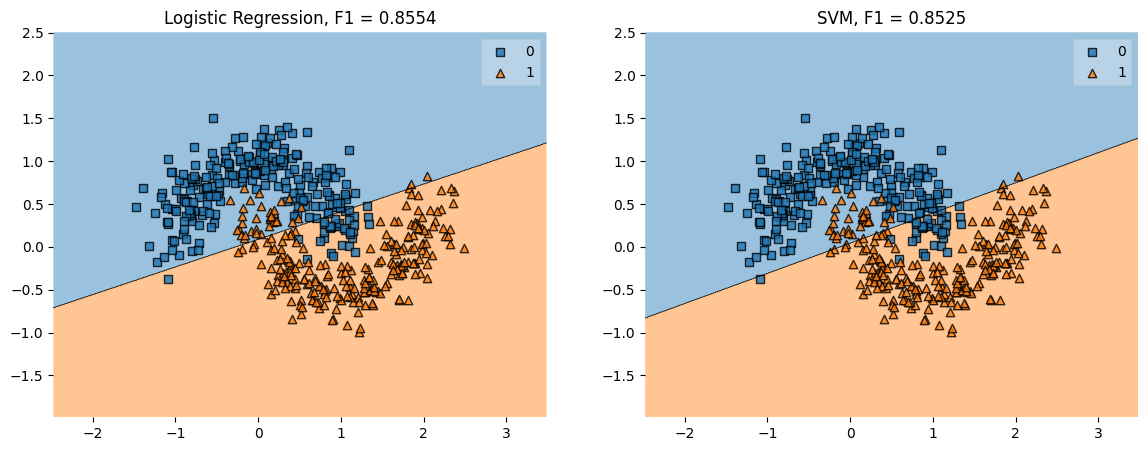

In [8]:
fig, axs = plt.subplots(figsize=(14, 5), ncols=2)

plot_decisions(
    X=moons_points, y=moons_labels, estimator=lr, ax=axs[0],
    title=f"Logistic Regression, F1 = {lr_f1:.4f}"
)

plot_decisions(
    X=moons_points, y=moons_labels, estimator=svm, ax=axs[1],
    title=f"SVM, F1 = {svm_f1:.4f}"
)

**Вывод:** видно, что линейные методы без дополнительных улучшений не подходят для решения этой задачи — классы не являются линейно разделимыми. Логистическая регрессия и SVM дают схожие значения F1-метрики (около 0.85), что подчеркивает их ограниченную эффективность в данном случае.

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

In [10]:
param_grids = {
    'linear': {
        'C': [1, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1]
    },
    'poly': {
        'C': [1, 0.9, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1],
        'degree': [2, 3, 4, 5, 6, 7, 8],
        'gamma': ['auto', 'scale'],
        'coef0': [1, 2, 2.5, 2.8, 2.9, 3, 3.1, 3.2]
    },
    'rbf': {
        'C': [1, 0.9, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1],
        'gamma': ['auto', 'scale']
    },
    'sigmoid': {
        'C': [1, 0.9, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1],
        'gamma': ['auto', 'scale'],
        'coef0': [0.5, 0.75, 0.9, 0.95, 1, 1.05, 1.1]
    }
}

Linear Kernel Best Params: {'C': 0.1}
F1 Score: 0.8577

Poly Kernel Best Params: {'C': 1, 'coef0': 2, 'degree': 7, 'gamma': 'scale'}
F1 Score: 0.9861

Rbf Kernel Best Params: {'C': 1, 'gamma': 'scale'}
F1 Score: 0.9738

Sigmoid Kernel Best Params: {'C': 0.1, 'coef0': 1, 'gamma': 'auto'}
F1 Score: 0.8242



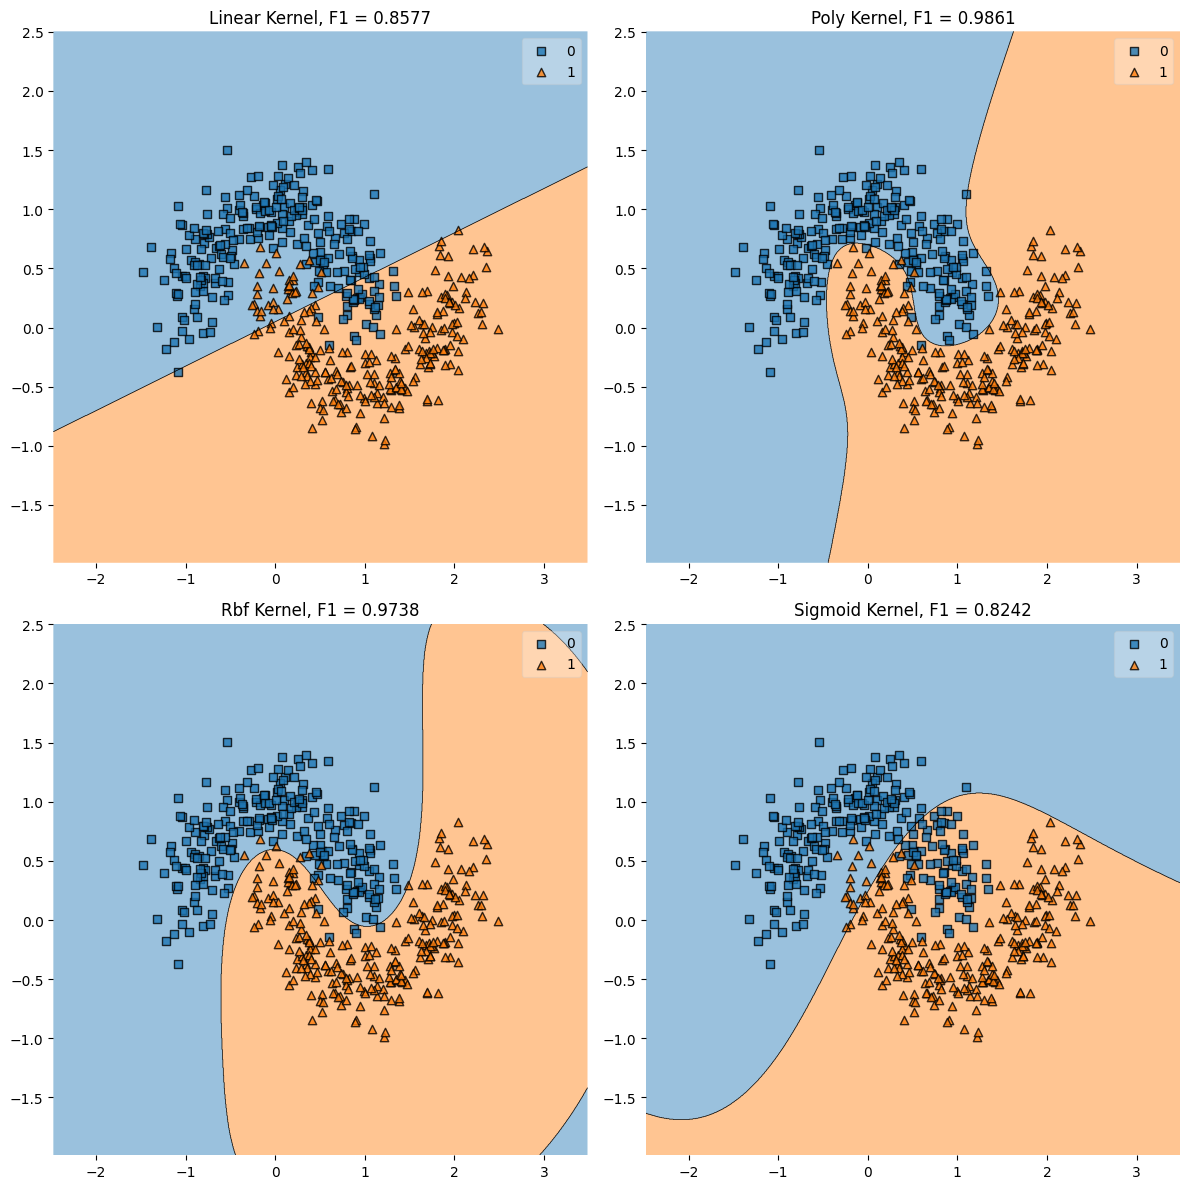

In [12]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
fig, axs = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)

for i, (kernel, params) in enumerate(param_grids.items()):
    svc = SVC(kernel=kernel)
    grid = GridSearchCV(svc, params, scoring='f1_macro', n_jobs=-1, cv=5)
    grid.fit(moons_points, moons_labels)

    best_model = grid.best_estimator_
    f1 = f1_score(moons_labels, best_model.predict(moons_points))

    ax = axs[i // 2, i % 2]
    plot_decisions(
        X=moons_points, y=moons_labels, estimator=best_model, ax=ax,
        title=f"{kernel.capitalize()} Kernel, F1 = {f1:.4f}"
    )

    print(f"{kernel.capitalize()} Kernel Best Params:", grid.best_params_)
    print(f"F1 Score: {f1:.4f}\n")

plt.tight_layout()

**Вывод:** полиномиальное и RBF ядра показали хорошие результаты, однако при использовании сигмоиды возникли проблемы с качеством классификации.

Тем не менее, RBF не совсем корректно сформировало разделяющую поверхность: на "половине" класса 1 с отступом снова появляется "зона" класса 0. Полиномиальное ядро такой проблемы не имеет и демонстрирует немного более высокую метрику.

Также важно отметить, что для полиномиального ядра критично было выбрать подходящие значения для степени и параметра coef0 — с значением по умолчанию (coef0 = 0) качество модели значительно снижалось.

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [17]:
def my_decision_plot(points, labels, clf, figsize, title='', data_transformer=None):
    xmin, xmax = points[:, 0].min(), points[:, 0].max()
    ymin, ymax = points[:, 1].min(), points[:, 1].max()
    x_edges = [xmin - (xmax - xmin) / 10, xmax + (xmax - xmin) / 10]
    y_edges = [ymin - (ymax - ymin) / 10, ymax + (ymax - ymin) / 10]

    x = np.linspace(*x_edges, 1000)
    y = np.linspace(*y_edges, 1000)
    xx, yy = np.meshgrid(x, y)
    coords = np.c_[xx.ravel(), yy.ravel()]

    if data_transformer:
        coords = data_transformer.transform(coords)

    pred_grid = clf.predict_proba(coords)[:, 1].reshape(len(x), len(y))

    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, pred_grid, levels=50, cmap="coolwarm", alpha=0.7)
    plt.colorbar(label="Probability of Class 1")

    scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, cmap="coolwarm", edgecolor='k', s=50)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlim(x_edges)
    plt.ylim(y_edges)
    plt.show()

In [18]:
def plot_logistic_poly(degrees, points, labels):
    for degree in degrees:
        pol_transformer = PolynomialFeatures(degree)
        X_pol = pol_transformer.fit_transform(points)

        pol_lr = LogisticRegression(penalty='elasticnet', l1_ratio=0.6, solver='saga', max_iter=10000)
        pol_lr.fit(X_pol, labels)

        pol_lr_f1 = f1_score(labels, pol_lr.predict(X_pol))

        my_decision_plot(
            points, labels, pol_lr,
            figsize=(8, 6),
            title=f"Polynomial Degree = {degree}, F1 = {pol_lr_f1:.4f}",
            data_transformer=pol_transformer
        )

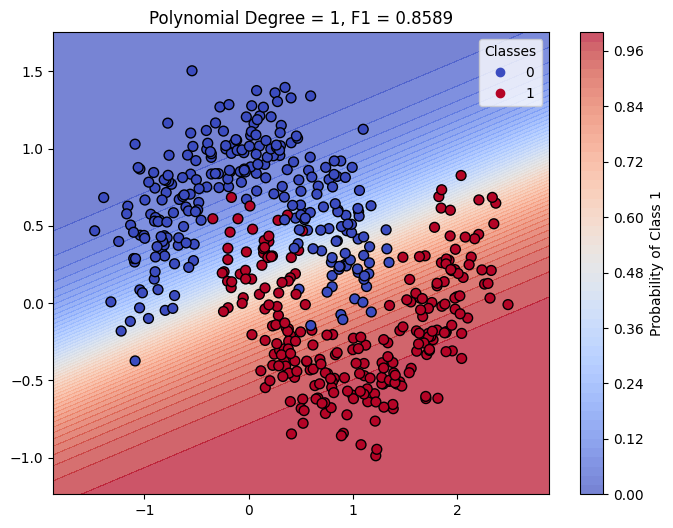

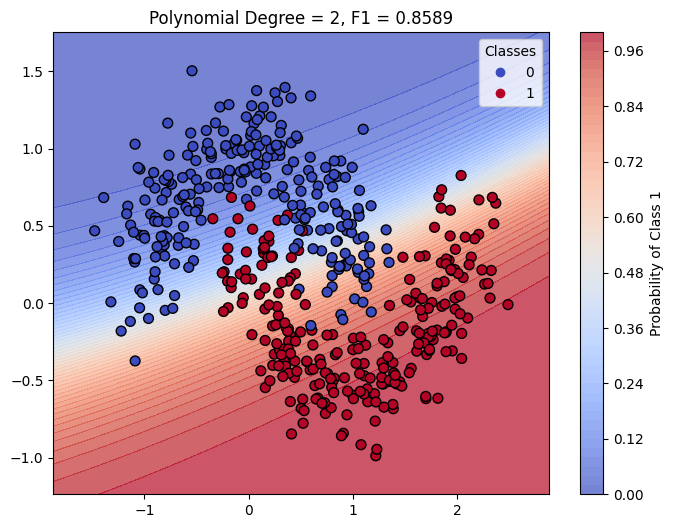

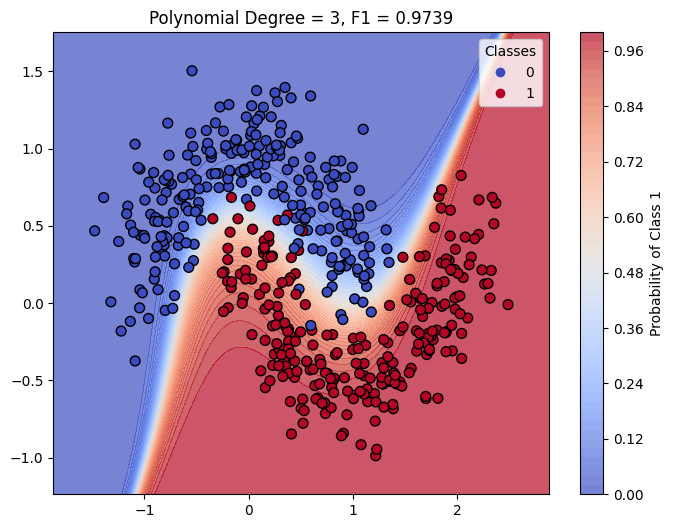

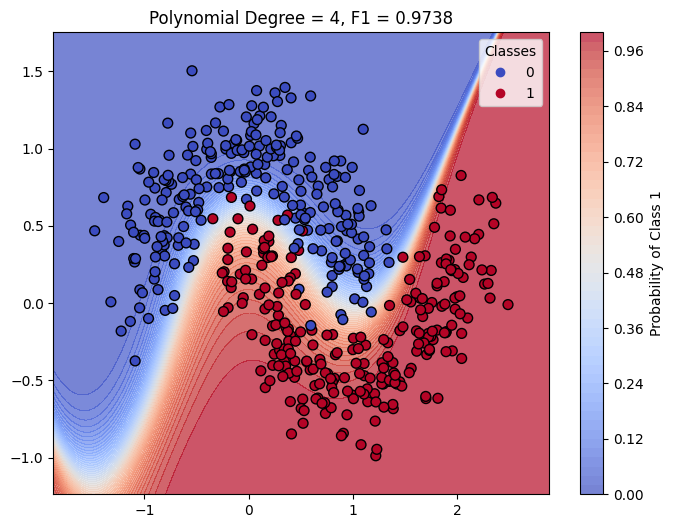

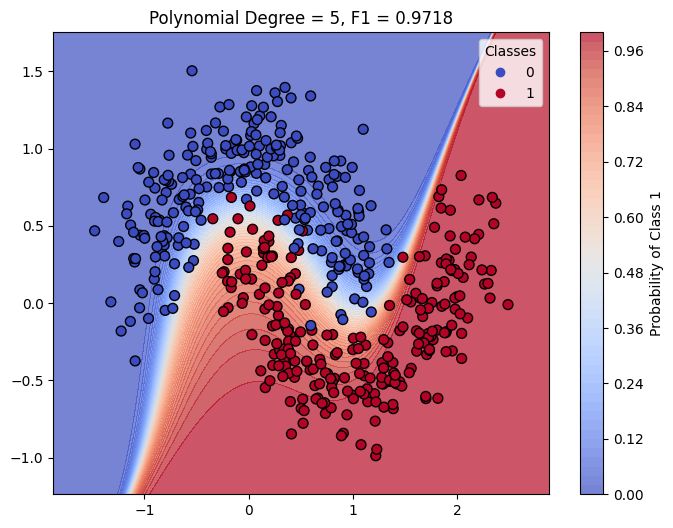

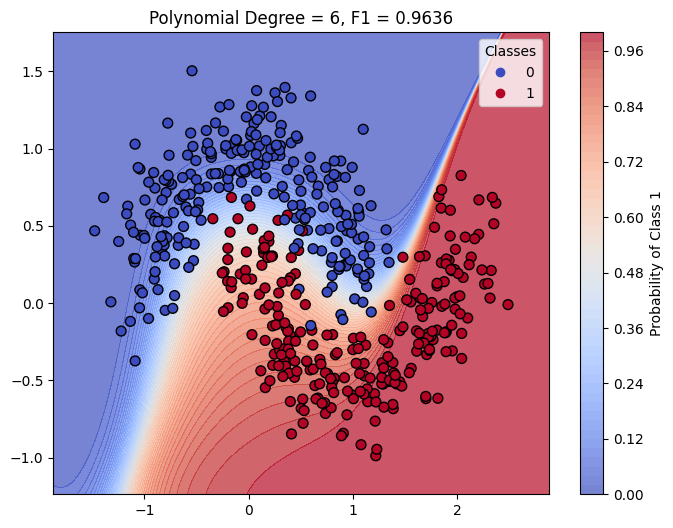

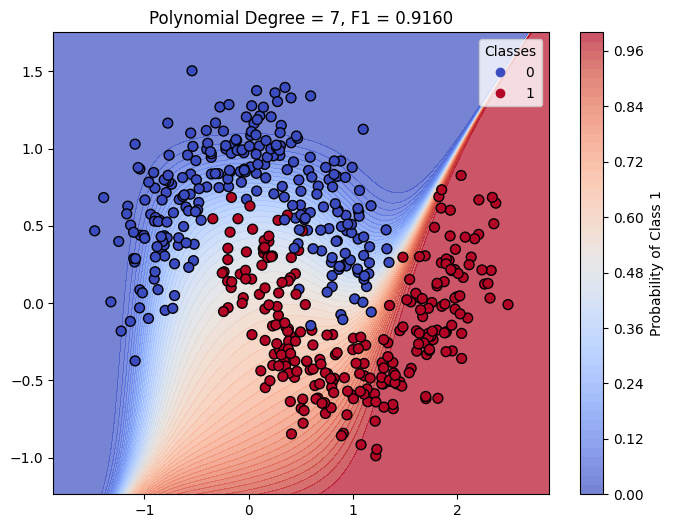

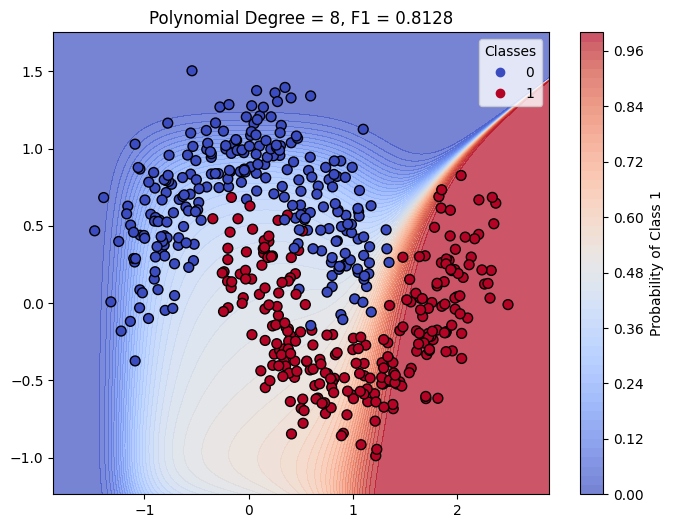

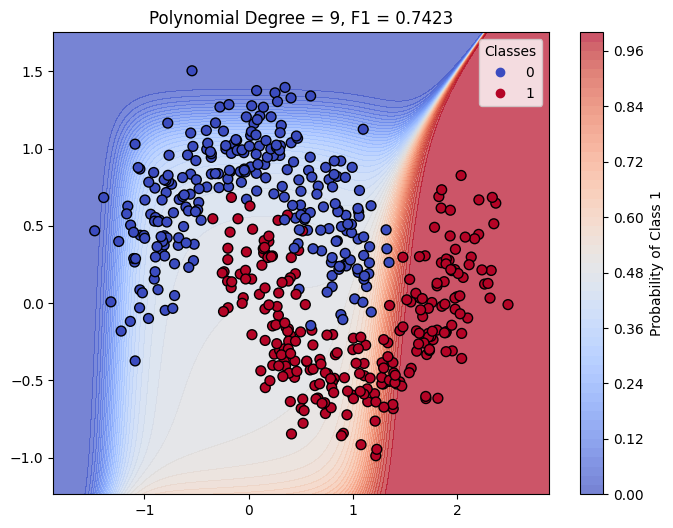

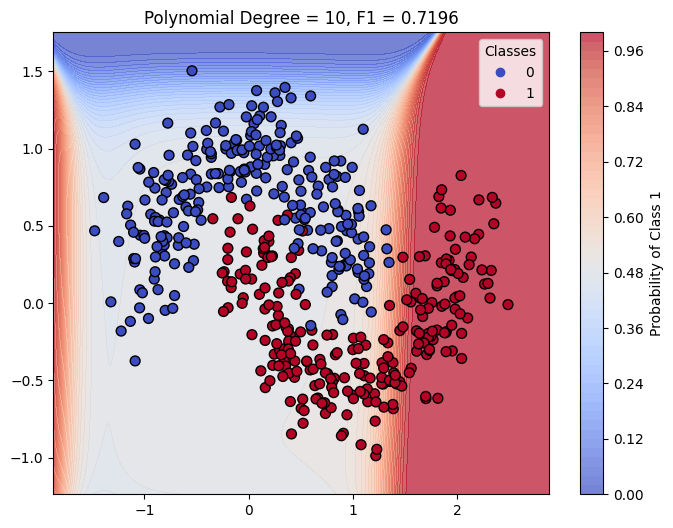

In [20]:
degrees = np.arange(1, 11)
plot_logistic_poly(degrees, moons_points, moons_labels)

**Вывод:** добавление полиномиальных признаков к логистической регрессии оказалось весьма полезным! Для полиномов степени 3 и 4 метрика достигает уровня SVM с RBF ядром.

Однако полиномы более высоких степеней снижают качество: метрика падает, модель начинает давать «размытые» разделяющие поверхности и плохо отражает форму данных. Таким образом, если для полиномиального SVM оптимальными степенями были 6-7, то логистическая регрессия показывает наилучшие результаты с полиномиальными признаками степени 3-4.

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

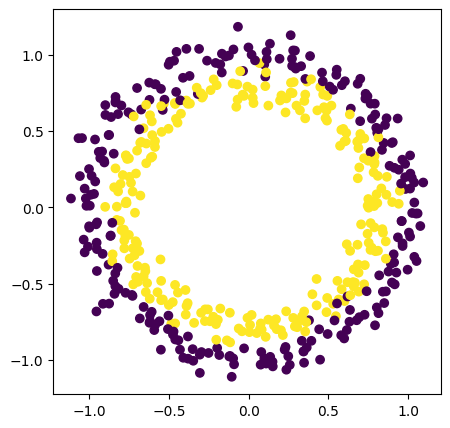

In [21]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

In [24]:
def evaluate_svm_kernels(X, y):
    kernels_params = [
        ("Linear", SVC(kernel='linear'), {'C': [1, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1]}),
        ("Polynomial", SVC(kernel='poly'), {
            'C': [1, 0.9, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1],
            'degree': [2, 3, 4, 5, 6, 7, 8],
            'gamma': ['auto', 'scale'],
            'coef0': [1, 2, 2.5, 2.8, 2.9, 3, 3.1, 3.2]
        }),
        ("RBF", SVC(kernel='rbf'), {
            'C': [1, 0.9, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1],
            'gamma': ['auto', 'scale']
        }),
        ("Sigmoid", SVC(kernel='sigmoid'), {
            'C': [1, 0.9, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1],
            'gamma': ['auto', 'scale'],
            'coef0': [0.5, 0.75, 0.9, 0.95, 1, 1.05, 1.1]
        })
    ]

    fig, axs = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)

    for idx, (kernel_name, model, param_grid) in enumerate(kernels_params):
        grid_search = GridSearchCV(model, param_grid, scoring='f1_macro', n_jobs=-1, cv=5)
        grid_search.fit(X, y)

        best_params = grid_search.best_params_
        f1 = f1_score(y, grid_search.predict(X))

        print(f"{kernel_name} Kernel - Best Params: {best_params}, F1 Score: {f1:.4f}\n")

        plot_decision_regions(X=X, y=y, clf=grid_search, ax=axs[idx // 2, idx % 2])
        axs[idx // 2, idx % 2].set_title(f"{kernel_name} Kernel, F1 = {f1:.4f}")

Linear Kernel - Best Params: {'C': 1}, F1 Score: 0.5116

Polynomial Kernel - Best Params: {'C': 0.6, 'coef0': 2.9, 'degree': 6, 'gamma': 'scale'}, F1 Score: 0.9459

RBF Kernel - Best Params: {'C': 0.9, 'gamma': 'scale'}, F1 Score: 0.9315

Sigmoid Kernel - Best Params: {'C': 0.5, 'coef0': 0.75, 'gamma': 'scale'}, F1 Score: 0.4890



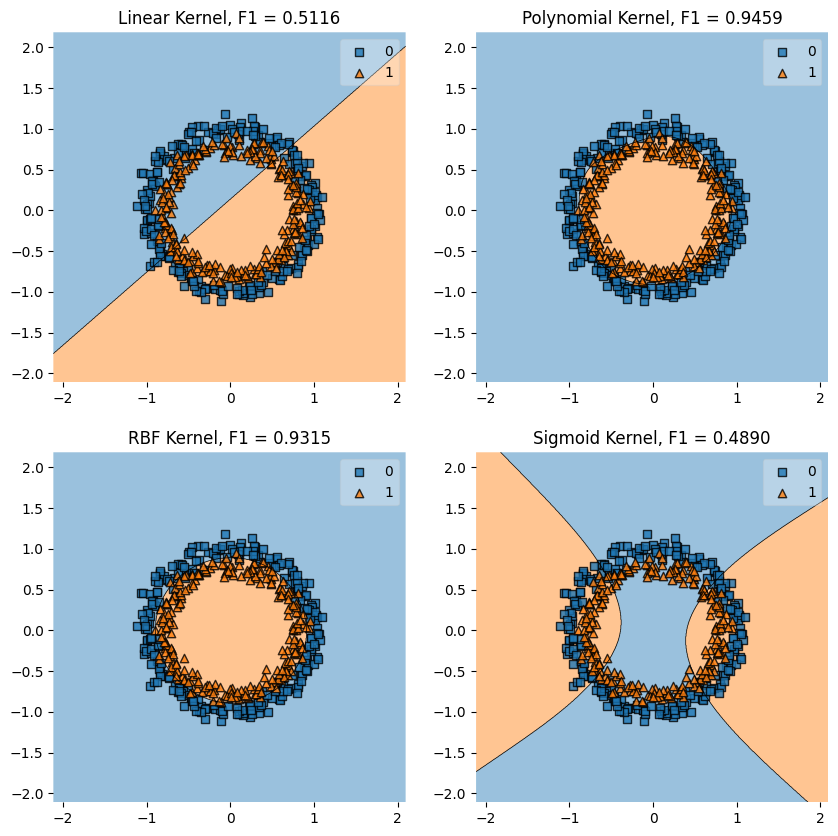

In [25]:
evaluate_svm_kernels(circles_points, circles_labels)

And even more:

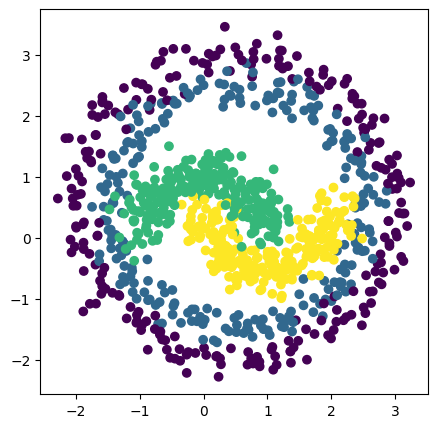

In [27]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

In [31]:
lin = SVC(kernel='linear')
lin_grid = {
    'C' :  [1, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1],
  }
lin_grid = GridSearchCV(lin, lin_grid, scoring='f1_macro', n_jobs=-1, cv=3)


poly = SVC(kernel='poly')
poly_grid = {
    'C' :  [1, 0.8, 0.6, 0.4, 0.2, 0.1],
    'degree' : [4, 5, 6, 7, 8],
    'gamma' : ['auto', 'scale'],
    'coef0' : [1, 2, 2.5, 2.8, 2.9, 3, 3.2]
  }
poly_grid = GridSearchCV(poly, poly_grid, scoring='f1_macro', n_jobs=-1, cv=3)


rbf = SVC(kernel='rbf')
rbf_grid = {
    'C' :  [1, 0.9, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1],
    'gamma' : ['auto', 'scale']
  }
rbf_grid = GridSearchCV(rbf, rbf_grid, scoring='f1_macro', n_jobs=-1, cv=3)


sigmoid = SVC(kernel='sigmoid')
sigmoid_grid = {
    'C' :  [1, 0.9, 0.8, 0.6, 0.5, 0.4, 0.2, 0.1],
    'gamma' : ['auto', 'scale'],
    'coef0' : [0.5, 0.9, 0.95, 1, 1.1]
  }
sigmoid_grid = GridSearchCV(sigmoid, sigmoid_grid, scoring='f1_macro', n_jobs=-1, cv=3)

Linear
{'C': 0.2}





/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


Polynomial
{'C': 0.4, 'coef0': 2.5, 'degree': 6, 'gamma': 'scale'}





/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


rbf
{'C': 0.9, 'gamma': 'auto'}





/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


sigmoid
{'C': 0.1, 'coef0': 0.5, 'gamma': 'scale'}





/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


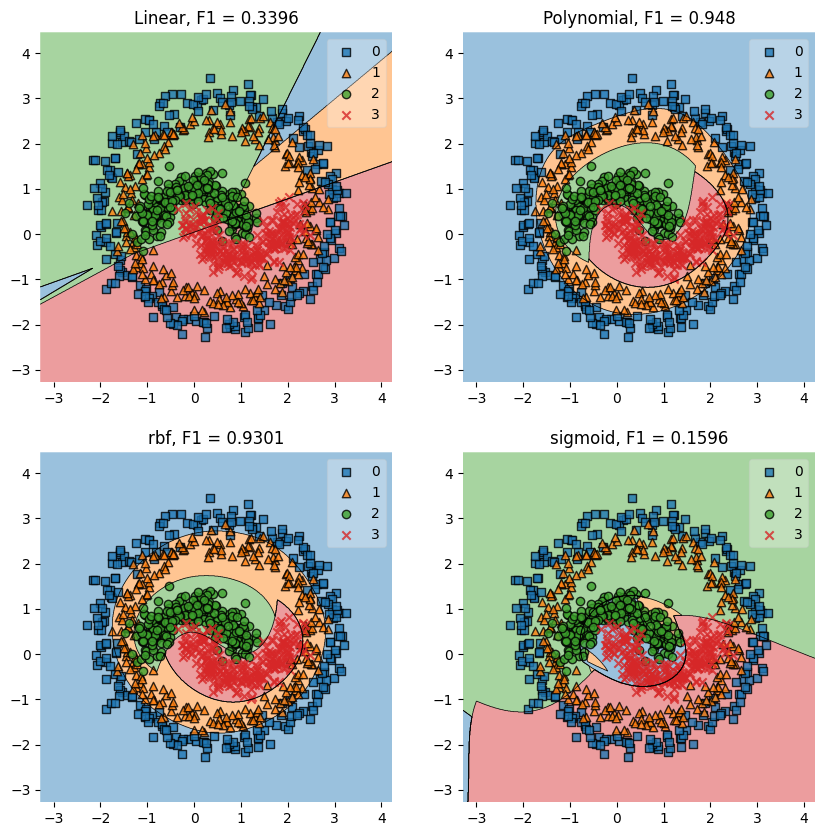

In [32]:
models = [lin_grid, poly_grid, rbf_grid, sigmoid_grid]

names = ['Linear', 'Polynomial', 'rbf', 'sigmoid']
fig, axs = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)

for i in range(2):
    for j in range(2):
        k = 2*i + j
        models[k].fit(points, labels)

        print(names[k])
        print(models[k].best_params_)
        print('\n\n')

        f1 = f1_score(labels, models[k].predict(points), average='macro')
        plot_decision_regions(X=points, y=labels, clf=models[k], ax=axs[i, j])
        axs[i, j].set_title(f"{names[k]}, F1 = {f1.round(4)}")

**Вывод:** SVM с полиномиальным ядром действительно продемонстрировал отличные результаты, уверенно справившись с задачей и показав высокие метрики. RBF ядро также оказалось близко по качеству, хотя немного уступает. Линейное ядро и сигмоидное заметно хуже справляются, при этом сигмоида даже слабее линейного. В итоге, полиномиальное ядро с оптимальной степенью 6 оказалось наилучшим решением.